# Out-of-sample forecasting experiments

I conduct out-of-sample forecasting experiments to understand what kind of text data (topics, sentiment, or uncertainty) helps improve forecasts of three quarterly variables (GDP, Investment, and Consumption) more.

In this notebook, I evaluate the performance of dynamic factor models (DFM) using hard data, survey information, and 10 sentiment-adjusted topics (BPW) most highly correlated with GDP growth (out of 200 topics estimated on articles published before 2008 using all sources). I forecast GDP growth and integrate text data into economic forecasting.

## Experiment Details

- **Data Sources:** Hard data, surveys, 10 sentiment-adjusted topics, BPW (<=2007, 200 topics, all sources).
- **Forecast Target:** GDP growth.
- **Model:** Dynamic Factor Models (DFM).
- **Parameters Explored:**
  - **Number of Hard+Surveys Factors:** 1 to 2
  - **Number of Text Factors:** 1
  - **Factor Order:** 1 to 3

In [1]:
import os
import time
import datetime
import pandas as pd
import DFM_function

# Define inputs common to all models
q_var = 'GDP'                             # quarterly variable being forecasted
additional_factors = 'HardSurveys+Text'   # switch to separate factors scenario
start = '1991-04'
text_type = "topics_BPW"
estimation_period = "2007"
num_topics = "200"
source = "all"
with_text = True

# Generate list of forecast_month strings for quarters from 2008Q1 to 2018Q4
# forecast_month is set to the month corresponding to quarter-end:
# Q1: 'YYYY-03', Q2: 'YYYY-06', Q3: 'YYYY-09', Q4: 'YYYY-12'
forecast_months = []
for year in range(2008, 2019):
    forecast_months.extend([f"{year}-03", f"{year}-06", f"{year}-09", f"{year}-12"])
    
# Define the vintage column names 
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Create directories to save forecasts and MSE results
os.makedirs(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", exist_ok=True)
os.makedirs(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", exist_ok=True)

# Load the actual growth data
actual_growth_file = f"../{q_var}_growth_actual.csv"
actual_growth = pd.read_csv(actual_growth_file)

# Record overall start time
overall_start = time.time()

# Loop over the number of HardSurveys factors (1 or 2) and factor order values from 1 to 3
for num_factors in range(1, 3):  # 1 or 2 HardSurveys factors
    for order in range(1, 4):    # Varying factor order: 1, 2, 3
        
        # Define model-specific parameters
        factor_multiplicities = {'HardSurveys': num_factors, 'Text': 1}
        factor_orders = {'HardSurveys': order, 'Text': order}

        # Prepare lists to store each quarter's forecasts and row labels
        forecasts_all_quarters = []
        row_labels = []
        
        # Start timing for this model
        start_time = time.time()

        # Loop over each forecast month, get the forecasts, and store the results
        for fm in forecast_months:
            # Use the forecast_month string as the row label
            row_labels.append(fm)

            # Run the forecast function for this quarter
            forecasts_dict = DFM_function.get_forecasts(
                forecast_month = fm,
                q_var = q_var,
                additional_factors = additional_factors,
                factor_multiplicities = factor_multiplicities,
                factor_orders = factor_orders,
                start = start,
                text_type = text_type,
                estimation_period = estimation_period,
                num_topics = num_topics,
                source = source,
                with_text = with_text
            )

            # Obtain the correct ordering of vintages
            vintages_order = DFM_function.vintage_dates(fm)
            # Extract the forecast value for each vintage in that order
            quarter_forecasts = [forecasts_dict[vint] for vint in vintages_order]
            forecasts_all_quarters.append(quarter_forecasts)

        # Create a DataFrame with rows labeled by the forecast_month strings and columns as vintage names
        results = pd.DataFrame(forecasts_all_quarters, index=row_labels, columns=vintage_col_names)
        
        # Stop timing for this model and print elapsed time
        elapsed = time.time() - start_time
        elapsed_time = datetime.timedelta(seconds=elapsed)
        print(f"Model with HardSurveys factors = {num_factors} and order = {order} estimated in {elapsed_time}.")

        # Construct the output file name
        factors_str = f"HS_{num_factors}_{order}"
        file_name = f"forecasts_{q_var}_{factors_str}.csv"

        # Save the CSV file in a subfolder 
        output_path = os.path.join(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", file_name)
        results.to_csv(output_path, index=True)
        
        # ----- MSE Calculation -----
        # Load forecasts
        forecasts = pd.read_csv(output_path, index_col=0)
        # Make sure the index is a column named "date"
        forecasts.index.name = "date"
        forecasts.reset_index(inplace=True)

        # Merge dfs by date 
        merged = pd.merge(forecasts, actual_growth, on="date", how="inner")

        # Calculate the Mean Squared Error (MSE) for each vintage column
        mse_dict = {}
        for col in vintage_col_names:
            mse = ((merged[col] - merged["growth"]) ** 2).mean()
            mse_dict[col] = mse

        # Create a df with one row (the MSE values for each forecasting horizon)
        mse_df = pd.DataFrame(mse_dict, index=[0])

        # Save MSE results to CSV
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_output_path = os.path.join(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", mse_file_name)
        mse_df.to_csv(mse_output_path, index=False)
        
# Stop overall timing and print overall elapsed time
overall_elapsed = time.time() - overall_start
overall_elapsed_time = datetime.timedelta(seconds=overall_elapsed)
print(f"Overall time taken for running all models: {overall_elapsed_time}.")

EM start iterations, llf=-11304
EM iteration 50, llf=-11072, convergence criterion=1.8304e-06
EM converged at iteration 67, llf=-11072, convergence criterion=9.8097e-07 < tolerance=1e-06
EM start iterations, llf=-11316
EM iteration 50, llf=-11084, convergence criterion=1.8281e-06
EM converged at iteration 67, llf=-11084, convergence criterion=9.7969e-07 < tolerance=1e-06
EM start iterations, llf=-11367
EM iteration 50, llf=-11132, convergence criterion=1.8258e-06
EM converged at iteration 67, llf=-11132, convergence criterion=9.7828e-07 < tolerance=1e-06
EM start iterations, llf=-11375
EM iteration 50, llf=-11141, convergence criterion=1.8168e-06
EM converged at iteration 67, llf=-11140, convergence criterion=9.7363e-07 < tolerance=1e-06
EM start iterations, llf=-11448
EM iteration 50, llf=-11207, convergence criterion=1.8015e-06
EM converged at iteration 66, llf=-11207, convergence criterion=9.9843e-07 < tolerance=1e-06
EM start iterations, llf=-11456
EM iteration 50, llf=-11214, conv

EM start iterations, llf=-12341
EM converged at iteration 44, llf=-12140, convergence criterion=9.9368e-07 < tolerance=1e-06
EM start iterations, llf=-12392
EM converged at iteration 45, llf=-12187, convergence criterion=9.7079e-07 < tolerance=1e-06
EM start iterations, llf=-12402
EM converged at iteration 49, llf=-12198, convergence criterion=9.9754e-07 < tolerance=1e-06
EM start iterations, llf=-12454
EM iteration 50, llf=-12246, convergence criterion=9.6819e-07
EM converged at iteration 50, llf=-12246, convergence criterion=9.6819e-07 < tolerance=1e-06
EM start iterations, llf=-12463
EM iteration 50, llf=-12255, convergence criterion=9.6503e-07
EM converged at iteration 50, llf=-12255, convergence criterion=9.6503e-07 < tolerance=1e-06
EM start iterations, llf=-12513
EM converged at iteration 49, llf=-12306, convergence criterion=9.9288e-07 < tolerance=1e-06
EM start iterations, llf=-12513
EM converged at iteration 49, llf=-12306, convergence criterion=9.9288e-07 < tolerance=1e-06
E

EM start iterations, llf=-13825
EM converged at iteration 49, llf=-13632, convergence criterion=9.8424e-07 < tolerance=1e-06
EM start iterations, llf=-13876
EM converged at iteration 49, llf=-13686, convergence criterion=9.7776e-07 < tolerance=1e-06
EM start iterations, llf=-13885
EM converged at iteration 49, llf=-13691, convergence criterion=9.8879e-07 < tolerance=1e-06
EM start iterations, llf=-13934
EM converged at iteration 49, llf=-13743, convergence criterion=9.812e-07 < tolerance=1e-06
EM start iterations, llf=-13934
EM converged at iteration 49, llf=-13743, convergence criterion=9.812e-07 < tolerance=1e-06
EM start iterations, llf=-13943
EM converged at iteration 49, llf=-13750, convergence criterion=9.8647e-07 < tolerance=1e-06
EM start iterations, llf=-13996
EM converged at iteration 49, llf=-13802, convergence criterion=9.8617e-07 < tolerance=1e-06
EM start iterations, llf=-14006
EM converged at iteration 49, llf=-13810, convergence criterion=9.7883e-07 < tolerance=1e-06
EM

EM start iterations, llf=-15541
EM converged at iteration 44, llf=-15325, convergence criterion=9.8215e-07 < tolerance=1e-06
EM start iterations, llf=-15541
EM converged at iteration 44, llf=-15325, convergence criterion=9.8215e-07 < tolerance=1e-06
EM start iterations, llf=-15550
EM converged at iteration 44, llf=-15334, convergence criterion=9.8942e-07 < tolerance=1e-06
EM start iterations, llf=-15601
EM converged at iteration 44, llf=-15384, convergence criterion=9.8517e-07 < tolerance=1e-06
EM start iterations, llf=-15611
EM converged at iteration 44, llf=-15394, convergence criterion=9.9488e-07 < tolerance=1e-06
EM start iterations, llf=-15658
EM converged at iteration 44, llf=-15440, convergence criterion=9.8743e-07 < tolerance=1e-06
EM start iterations, llf=-15665
EM converged at iteration 44, llf=-15447, convergence criterion=9.91e-07 < tolerance=1e-06
EM start iterations, llf=-15716
EM converged at iteration 44, llf=-15497, convergence criterion=9.8862e-07 < tolerance=1e-06
EM

EM start iterations, llf=-17199
EM converged at iteration 41, llf=-16964, convergence criterion=9.6477e-07 < tolerance=1e-06
EM start iterations, llf=-17207
EM converged at iteration 41, llf=-16973, convergence criterion=9.7023e-07 < tolerance=1e-06
EM start iterations, llf=-17255
EM converged at iteration 41, llf=-17020, convergence criterion=9.7296e-07 < tolerance=1e-06
EM start iterations, llf=-17263
EM converged at iteration 41, llf=-17027, convergence criterion=9.7288e-07 < tolerance=1e-06
EM start iterations, llf=-17316
EM converged at iteration 41, llf=-17080, convergence criterion=9.7262e-07 < tolerance=1e-06
EM start iterations, llf=-17316
EM converged at iteration 41, llf=-17080, convergence criterion=9.7262e-07 < tolerance=1e-06
EM start iterations, llf=-17320
EM converged at iteration 41, llf=-17083, convergence criterion=9.7933e-07 < tolerance=1e-06
EM start iterations, llf=-17372
EM converged at iteration 41, llf=-17134, convergence criterion=9.7455e-07 < tolerance=1e-06


EM start iterations, llf=-18370
EM converged at iteration 41, llf=-18111, convergence criterion=9.6828e-07 < tolerance=1e-06
EM start iterations, llf=-18422
EM converged at iteration 41, llf=-18163, convergence criterion=9.6178e-07 < tolerance=1e-06
Model with HardSurveys factors = 1 and order = 1 estimated in 1:40:48.027988.
EM start iterations, llf=-11300
EM iteration 50, llf=-11061, convergence criterion=2.6902e-06
EM converged at iteration 81, llf=-11061, convergence criterion=9.804e-07 < tolerance=1e-06
EM start iterations, llf=-11313
EM iteration 50, llf=-11073, convergence criterion=2.6883e-06
EM converged at iteration 81, llf=-11073, convergence criterion=9.7972e-07 < tolerance=1e-06
EM start iterations, llf=-11363
EM iteration 50, llf=-11122, convergence criterion=2.7358e-06
EM converged at iteration 82, llf=-11121, convergence criterion=9.7653e-07 < tolerance=1e-06
EM start iterations, llf=-11371
EM iteration 50, llf=-11130, convergence criterion=2.7427e-06
EM converged at it

EM iteration 50, llf=-11945, convergence criterion=1.6879e-06
EM converged at iteration 65, llf=-11945, convergence criterion=9.9673e-07 < tolerance=1e-06
EM start iterations, llf=-12161
EM iteration 50, llf=-11952, convergence criterion=1.6778e-06
EM converged at iteration 65, llf=-11951, convergence criterion=9.9093e-07 < tolerance=1e-06
EM start iterations, llf=-12204
EM iteration 50, llf=-11993, convergence criterion=1.6557e-06
EM converged at iteration 65, llf=-11993, convergence criterion=9.7592e-07 < tolerance=1e-06
EM start iterations, llf=-12215
EM iteration 50, llf=-12005, convergence criterion=1.3899e-06
EM converged at iteration 59, llf=-12005, convergence criterion=9.8523e-07 < tolerance=1e-06
EM start iterations, llf=-12261
EM iteration 50, llf=-12045, convergence criterion=1.399e-06
EM converged at iteration 59, llf=-12045, convergence criterion=9.8907e-07 < tolerance=1e-06
EM start iterations, llf=-12272
EM iteration 50, llf=-12055, convergence criterion=1.3935e-06
EM c

EM iteration 50, llf=-13134, convergence criterion=2.0288e-06
EM converged at iteration 75, llf=-13133, convergence criterion=9.8813e-07 < tolerance=1e-06
EM start iterations, llf=-13334
EM iteration 50, llf=-13136, convergence criterion=1.9544e-06
EM converged at iteration 74, llf=-13136, convergence criterion=9.787e-07 < tolerance=1e-06
EM start iterations, llf=-13360
EM iteration 50, llf=-13155, convergence criterion=1.8893e-06
EM converged at iteration 72, llf=-13154, convergence criterion=9.8577e-07 < tolerance=1e-06
EM start iterations, llf=-13365
EM iteration 50, llf=-13167, convergence criterion=1.9617e-06
EM converged at iteration 74, llf=-13166, convergence criterion=9.7759e-07 < tolerance=1e-06
EM start iterations, llf=-13405
EM iteration 50, llf=-13214, convergence criterion=2.1051e-06
EM converged at iteration 78, llf=-13214, convergence criterion=9.8636e-07 < tolerance=1e-06
EM start iterations, llf=-13405
EM iteration 50, llf=-13214, convergence criterion=2.1051e-06
EM c

EM iteration 50, llf=-14211, convergence criterion=1.669e-06
EM converged at iteration 75, llf=-14211, convergence criterion=9.8178e-07 < tolerance=1e-06
EM start iterations, llf=-14415
EM iteration 50, llf=-14218, convergence criterion=1.7162e-06
EM converged at iteration 74, llf=-14217, convergence criterion=9.9193e-07 < tolerance=1e-06
EM start iterations, llf=-14464
EM iteration 50, llf=-14263, convergence criterion=1.7848e-06
EM converged at iteration 73, llf=-14262, convergence criterion=9.9305e-07 < tolerance=1e-06
EM start iterations, llf=-14464
EM iteration 50, llf=-14263, convergence criterion=1.7848e-06
EM converged at iteration 73, llf=-14262, convergence criterion=9.9305e-07 < tolerance=1e-06
EM start iterations, llf=-14473
EM iteration 50, llf=-14272, convergence criterion=1.7817e-06
EM converged at iteration 73, llf=-14272, convergence criterion=9.9197e-07 < tolerance=1e-06
EM start iterations, llf=-14524
EM iteration 50, llf=-14323, convergence criterion=1.7692e-06
EM c

EM iteration 50, llf=-15320, convergence criterion=1.4477e-06
EM converged at iteration 63, llf=-15320, convergence criterion=9.8324e-07 < tolerance=1e-06
EM start iterations, llf=-15541
EM iteration 50, llf=-15320, convergence criterion=1.4477e-06
EM converged at iteration 63, llf=-15320, convergence criterion=9.8324e-07 < tolerance=1e-06
EM start iterations, llf=-15550
EM iteration 50, llf=-15329, convergence criterion=1.4539e-06
EM converged at iteration 63, llf=-15328, convergence criterion=9.8418e-07 < tolerance=1e-06
EM start iterations, llf=-15601
EM iteration 50, llf=-15378, convergence criterion=1.4443e-06
EM converged at iteration 63, llf=-15378, convergence criterion=9.764e-07 < tolerance=1e-06
EM start iterations, llf=-15611
EM iteration 50, llf=-15389, convergence criterion=1.4544e-06
EM converged at iteration 63, llf=-15388, convergence criterion=9.8437e-07 < tolerance=1e-06
EM start iterations, llf=-15658
EM iteration 50, llf=-15435, convergence criterion=1.4484e-06
EM c

EM iteration 50, llf=-16397, convergence criterion=1.1837e-06
EM converged at iteration 57, llf=-16397, convergence criterion=9.7327e-07 < tolerance=1e-06
EM start iterations, llf=-16674
EM iteration 50, llf=-16445, convergence criterion=1.189e-06
EM converged at iteration 57, llf=-16445, convergence criterion=9.7724e-07 < tolerance=1e-06
EM start iterations, llf=-16681
EM iteration 50, llf=-16452, convergence criterion=1.1947e-06
EM converged at iteration 57, llf=-16452, convergence criterion=9.8195e-07 < tolerance=1e-06
EM start iterations, llf=-16731
EM iteration 50, llf=-16500, convergence criterion=1.1892e-06
EM converged at iteration 57, llf=-16500, convergence criterion=9.7592e-07 < tolerance=1e-06
EM start iterations, llf=-16739
EM iteration 50, llf=-16507, convergence criterion=1.1901e-06
EM converged at iteration 57, llf=-16507, convergence criterion=9.7471e-07 < tolerance=1e-06
EM start iterations, llf=-16785
EM iteration 50, llf=-16552, convergence criterion=1.1841e-06
EM c

EM iteration 50, llf=-17284, convergence criterion=1.1641e-06
EM converged at iteration 55, llf=-17284, convergence criterion=9.9173e-07 < tolerance=1e-06
EM start iterations, llf=-17587
EM iteration 50, llf=-17338, convergence criterion=1.1631e-06
EM converged at iteration 55, llf=-17338, convergence criterion=9.9043e-07 < tolerance=1e-06
EM start iterations, llf=-17593
EM iteration 50, llf=-17345, convergence criterion=1.1914e-06
EM converged at iteration 56, llf=-17345, convergence criterion=9.8566e-07 < tolerance=1e-06
EM start iterations, llf=-17650
EM iteration 50, llf=-17400, convergence criterion=1.1628e-06
EM converged at iteration 55, llf=-17400, convergence criterion=9.8949e-07 < tolerance=1e-06
EM start iterations, llf=-17650
EM iteration 50, llf=-17400, convergence criterion=1.1628e-06
EM converged at iteration 55, llf=-17400, convergence criterion=9.8949e-07 < tolerance=1e-06
EM start iterations, llf=-17655
EM iteration 50, llf=-17406, convergence criterion=1.1897e-06
EM 

EM iteration 50, llf=-18106, convergence criterion=1.1028e-06
EM converged at iteration 54, llf=-18106, convergence criterion=9.6998e-07 < tolerance=1e-06
EM start iterations, llf=-18422
EM iteration 50, llf=-18158, convergence criterion=1.0901e-06
EM converged at iteration 53, llf=-18158, convergence criterion=9.8986e-07 < tolerance=1e-06
Model with HardSurveys factors = 1 and order = 2 estimated in 2:19:41.963515.
EM start iterations, llf=-11291
EM iteration 50, llf=-11050, convergence criterion=2.6158e-06
EM converged at iteration 78, llf=-11050, convergence criterion=9.8344e-07 < tolerance=1e-06
EM start iterations, llf=-11304
EM iteration 50, llf=-11062, convergence criterion=2.6149e-06
EM converged at iteration 78, llf=-11062, convergence criterion=9.8327e-07 < tolerance=1e-06
EM start iterations, llf=-11355
EM iteration 50, llf=-11111, convergence criterion=2.6284e-06
EM converged at iteration 78, llf=-11111, convergence criterion=9.8788e-07 < tolerance=1e-06
EM start iterations

EM start iterations, llf=-12150
EM iteration 50, llf=-11937, convergence criterion=1.7556e-06
EM converged at iteration 66, llf=-11937, convergence criterion=9.7993e-07 < tolerance=1e-06
EM start iterations, llf=-12156
EM iteration 50, llf=-11943, convergence criterion=1.7512e-06
EM converged at iteration 66, llf=-11943, convergence criterion=9.7691e-07 < tolerance=1e-06
EM start iterations, llf=-12199
EM iteration 50, llf=-11985, convergence criterion=1.7332e-06
EM converged at iteration 65, llf=-11984, convergence criterion=9.9828e-07 < tolerance=1e-06
EM start iterations, llf=-12210
EM iteration 50, llf=-11997, convergence criterion=1.4719e-06
EM converged at iteration 60, llf=-11997, convergence criterion=9.8717e-07 < tolerance=1e-06
EM start iterations, llf=-12256
EM iteration 50, llf=-12038, convergence criterion=1.4218e-06
EM converged at iteration 59, llf=-12038, convergence criterion=9.8815e-07 < tolerance=1e-06
EM start iterations, llf=-12267
EM iteration 50, llf=-12048, conv

EM start iterations, llf=-13317
EM iteration 50, llf=-13128, convergence criterion=1.9691e-06
EM converged at iteration 71, llf=-13128, convergence criterion=9.894e-07 < tolerance=1e-06
EM start iterations, llf=-13325
EM iteration 50, llf=-13130, convergence criterion=1.9699e-06
EM converged at iteration 72, llf=-13130, convergence criterion=9.9426e-07 < tolerance=1e-06
EM start iterations, llf=-13352
EM iteration 50, llf=-13148, convergence criterion=1.9224e-06
EM converged at iteration 71, llf=-13148, convergence criterion=9.9784e-07 < tolerance=1e-06
EM start iterations, llf=-13357
EM iteration 50, llf=-13161, convergence criterion=1.9666e-06
EM converged at iteration 72, llf=-13160, convergence criterion=9.8894e-07 < tolerance=1e-06
EM start iterations, llf=-13396
EM iteration 50, llf=-13209, convergence criterion=2.0033e-06
EM converged at iteration 72, llf=-13208, convergence criterion=9.9081e-07 < tolerance=1e-06
EM start iterations, llf=-13396
EM iteration 50, llf=-13209, conve

EM start iterations, llf=-14400
EM iteration 50, llf=-14206, convergence criterion=1.8418e-06
EM converged at iteration 69, llf=-14206, convergence criterion=9.8338e-07 < tolerance=1e-06
EM start iterations, llf=-14407
EM iteration 50, llf=-14213, convergence criterion=1.8392e-06
EM converged at iteration 69, llf=-14212, convergence criterion=9.8366e-07 < tolerance=1e-06
EM start iterations, llf=-14457
EM iteration 50, llf=-14258, convergence criterion=1.8223e-06
EM converged at iteration 69, llf=-14257, convergence criterion=9.8209e-07 < tolerance=1e-06
EM start iterations, llf=-14457
EM iteration 50, llf=-14258, convergence criterion=1.8223e-06
EM converged at iteration 69, llf=-14257, convergence criterion=9.8209e-07 < tolerance=1e-06
EM start iterations, llf=-14466
EM iteration 50, llf=-14267, convergence criterion=1.8192e-06
EM converged at iteration 69, llf=-14267, convergence criterion=9.8037e-07 < tolerance=1e-06
EM start iterations, llf=-14516
EM iteration 50, llf=-14318, conv

EM start iterations, llf=-15532
EM iteration 50, llf=-15314, convergence criterion=1.5737e-06
EM converged at iteration 63, llf=-15313, convergence criterion=9.9944e-07 < tolerance=1e-06
EM start iterations, llf=-15532
EM iteration 50, llf=-15314, convergence criterion=1.5737e-06
EM converged at iteration 63, llf=-15313, convergence criterion=9.9944e-07 < tolerance=1e-06
EM start iterations, llf=-15541
EM iteration 50, llf=-15322, convergence criterion=1.5774e-06
EM converged at iteration 64, llf=-15322, convergence criterion=9.7027e-07 < tolerance=1e-06
EM start iterations, llf=-15592
EM iteration 50, llf=-15372, convergence criterion=1.5689e-06
EM converged at iteration 63, llf=-15371, convergence criterion=9.97e-07 < tolerance=1e-06
EM start iterations, llf=-15602
EM iteration 50, llf=-15382, convergence criterion=1.5782e-06
EM converged at iteration 64, llf=-15382, convergence criterion=9.7344e-07 < tolerance=1e-06
EM start iterations, llf=-15649
EM iteration 50, llf=-15428, conver

EM start iterations, llf=-16617
EM iteration 50, llf=-16391, convergence criterion=1.3153e-06
EM converged at iteration 58, llf=-16391, convergence criterion=9.9804e-07 < tolerance=1e-06
EM start iterations, llf=-16666
EM iteration 50, llf=-16439, convergence criterion=1.3145e-06
EM converged at iteration 58, llf=-16439, convergence criterion=9.9744e-07 < tolerance=1e-06
EM start iterations, llf=-16672
EM iteration 50, llf=-16446, convergence criterion=1.3214e-06
EM converged at iteration 59, llf=-16446, convergence criterion=9.713e-07 < tolerance=1e-06
EM start iterations, llf=-16722
EM iteration 50, llf=-16494, convergence criterion=1.319e-06
EM converged at iteration 59, llf=-16494, convergence criterion=9.6923e-07 < tolerance=1e-06
EM start iterations, llf=-16730
EM iteration 50, llf=-16501, convergence criterion=1.3178e-06
EM converged at iteration 58, llf=-16501, convergence criterion=9.9998e-07 < tolerance=1e-06
EM start iterations, llf=-16776
EM iteration 50, llf=-16546, conver

EM start iterations, llf=-17523
EM iteration 50, llf=-17277, convergence criterion=1.2671e-06
EM converged at iteration 57, llf=-17277, convergence criterion=9.872e-07 < tolerance=1e-06
EM start iterations, llf=-17579
EM iteration 50, llf=-17331, convergence criterion=1.2636e-06
EM converged at iteration 57, llf=-17331, convergence criterion=9.8442e-07 < tolerance=1e-06
EM start iterations, llf=-17585
EM iteration 50, llf=-17338, convergence criterion=1.2966e-06
EM converged at iteration 58, llf=-17338, convergence criterion=9.7936e-07 < tolerance=1e-06
EM start iterations, llf=-17641
EM iteration 50, llf=-17393, convergence criterion=1.26e-06
EM converged at iteration 57, llf=-17393, convergence criterion=9.8188e-07 < tolerance=1e-06
EM start iterations, llf=-17641
EM iteration 50, llf=-17393, convergence criterion=1.26e-06
EM converged at iteration 57, llf=-17393, convergence criterion=9.8188e-07 < tolerance=1e-06
EM start iterations, llf=-17647
EM iteration 50, llf=-17398, convergen

EM start iterations, llf=-18362
EM iteration 50, llf=-18098, convergence criterion=1.2662e-06
EM converged at iteration 57, llf=-18098, convergence criterion=9.8475e-07 < tolerance=1e-06
EM start iterations, llf=-18414
EM iteration 50, llf=-18150, convergence criterion=1.2637e-06
EM converged at iteration 57, llf=-18150, convergence criterion=9.8338e-07 < tolerance=1e-06
Model with HardSurveys factors = 1 and order = 3 estimated in 2:18:27.200745.
EM start iterations, llf=-10823
EM iteration 50, llf=-10689, convergence criterion=1.3491e-06
EM converged at iteration 58, llf=-10689, convergence criterion=9.9359e-07 < tolerance=1e-06
EM start iterations, llf=-10836
EM iteration 50, llf=-10701, convergence criterion=1.3515e-06
EM converged at iteration 58, llf=-10701, convergence criterion=9.9552e-07 < tolerance=1e-06
EM start iterations, llf=-10885
EM iteration 50, llf=-10751, convergence criterion=1.3462e-06
EM converged at iteration 58, llf=-10751, convergence criterion=9.9167e-07 < tol

EM start iterations, llf=-11848
EM converged at iteration 32, llf=-11697, convergence criterion=9.4552e-07 < tolerance=1e-06
EM start iterations, llf=-11896
EM converged at iteration 32, llf=-11746, convergence criterion=9.4144e-07 < tolerance=1e-06
EM start iterations, llf=-11896
EM converged at iteration 32, llf=-11746, convergence criterion=9.4144e-07 < tolerance=1e-06
EM start iterations, llf=-11909
EM converged at iteration 32, llf=-11757, convergence criterion=9.3972e-07 < tolerance=1e-06
EM start iterations, llf=-11954
EM converged at iteration 31, llf=-11804, convergence criterion=9.9159e-07 < tolerance=1e-06
EM start iterations, llf=-11968
EM converged at iteration 34, llf=-11818, convergence criterion=9.4582e-07 < tolerance=1e-06
EM start iterations, llf=-12008
EM converged at iteration 34, llf=-11860, convergence criterion=9.5712e-07 < tolerance=1e-06
EM start iterations, llf=-12059
EM converged at iteration 34, llf=-11907, convergence criterion=9.5317e-07 < tolerance=1e-06


EM start iterations, llf=-13390
EM converged at iteration 33, llf=-13232, convergence criterion=9.4247e-07 < tolerance=1e-06
EM start iterations, llf=-13433
EM converged at iteration 32, llf=-13275, convergence criterion=9.8835e-07 < tolerance=1e-06
EM start iterations, llf=-13440
EM converged at iteration 33, llf=-13282, convergence criterion=9.414e-07 < tolerance=1e-06
EM start iterations, llf=-13495
EM converged at iteration 33, llf=-13337, convergence criterion=9.5789e-07 < tolerance=1e-06
EM start iterations, llf=-13505
EM converged at iteration 33, llf=-13346, convergence criterion=9.6078e-07 < tolerance=1e-06
EM start iterations, llf=-13556
EM converged at iteration 34, llf=-13394, convergence criterion=9.93e-07 < tolerance=1e-06
EM start iterations, llf=-13556
EM converged at iteration 34, llf=-13394, convergence criterion=9.93e-07 < tolerance=1e-06
EM start iterations, llf=-13561
EM converged at iteration 33, llf=-13401, convergence criterion=9.7939e-07 < tolerance=1e-06
EM st

EM start iterations, llf=-15047
EM converged at iteration 26, llf=-14879, convergence criterion=9.2794e-07 < tolerance=1e-06
EM start iterations, llf=-15058
EM converged at iteration 25, llf=-14889, convergence criterion=9.9809e-07 < tolerance=1e-06
EM start iterations, llf=-15111
EM converged at iteration 25, llf=-14940, convergence criterion=9.9593e-07 < tolerance=1e-06
EM start iterations, llf=-15111
EM converged at iteration 25, llf=-14940, convergence criterion=9.9593e-07 < tolerance=1e-06
EM start iterations, llf=-15111
EM converged at iteration 26, llf=-14941, convergence criterion=9.3646e-07 < tolerance=1e-06
EM start iterations, llf=-15157
EM converged at iteration 26, llf=-14986, convergence criterion=9.3818e-07 < tolerance=1e-06
EM start iterations, llf=-15165
EM converged at iteration 26, llf=-14993, convergence criterion=9.3283e-07 < tolerance=1e-06
EM start iterations, llf=-15215
EM converged at iteration 26, llf=-15042, convergence criterion=9.2906e-07 < tolerance=1e-06


EM start iterations, llf=-16637
EM converged at iteration 28, llf=-16459, convergence criterion=9.5015e-07 < tolerance=1e-06
EM start iterations, llf=-16650
EM converged at iteration 28, llf=-16471, convergence criterion=9.5068e-07 < tolerance=1e-06
EM start iterations, llf=-16702
EM converged at iteration 28, llf=-16523, convergence criterion=9.4288e-07 < tolerance=1e-06
EM start iterations, llf=-16711
EM converged at iteration 28, llf=-16533, convergence criterion=9.5623e-07 < tolerance=1e-06
EM start iterations, llf=-16749
EM converged at iteration 28, llf=-16572, convergence criterion=9.4015e-07 < tolerance=1e-06
EM start iterations, llf=-16765
EM converged at iteration 28, llf=-16585, convergence criterion=9.3802e-07 < tolerance=1e-06
EM start iterations, llf=-16607
EM converged at iteration 27, llf=-16434, convergence criterion=9.8882e-07 < tolerance=1e-06
EM start iterations, llf=-16607
EM converged at iteration 27, llf=-16434, convergence criterion=9.8882e-07 < tolerance=1e-06


EM iteration 50, llf=-10876, convergence criterion=1.8125e-06
EM converged at iteration 70, llf=-10876, convergence criterion=9.7336e-07 < tolerance=1e-06
EM start iterations, llf=-11022
EM iteration 50, llf=-10876, convergence criterion=1.8125e-06
EM converged at iteration 70, llf=-10876, convergence criterion=9.7336e-07 < tolerance=1e-06
EM start iterations, llf=-11027
EM iteration 50, llf=-10883, convergence criterion=1.7713e-06
EM converged at iteration 69, llf=-10883, convergence criterion=9.7504e-07 < tolerance=1e-06
EM start iterations, llf=-11069
EM iteration 50, llf=-10925, convergence criterion=1.7399e-06
EM converged at iteration 68, llf=-10925, convergence criterion=9.8885e-07 < tolerance=1e-06
EM start iterations, llf=-11080
EM iteration 50, llf=-10936, convergence criterion=1.6873e-06
EM converged at iteration 67, llf=-10936, convergence criterion=9.8445e-07 < tolerance=1e-06
EM start iterations, llf=-11136
EM iteration 50, llf=-10988, convergence criterion=1.7085e-06
EM 

EM start iterations, llf=-12104
EM converged at iteration 39, llf=-11952, convergence criterion=9.8629e-07 < tolerance=1e-06
EM start iterations, llf=-12138
EM converged at iteration 40, llf=-11986, convergence criterion=9.9587e-07 < tolerance=1e-06
EM start iterations, llf=-12146
EM converged at iteration 41, llf=-11991, convergence criterion=9.8289e-07 < tolerance=1e-06
EM start iterations, llf=-12208
EM converged at iteration 41, llf=-12045, convergence criterion=9.8927e-07 < tolerance=1e-06
EM start iterations, llf=-12212
EM converged at iteration 41, llf=-12052, convergence criterion=9.6625e-07 < tolerance=1e-06
EM start iterations, llf=-12253
EM converged at iteration 39, llf=-12093, convergence criterion=9.8836e-07 < tolerance=1e-06
EM start iterations, llf=-12253
EM converged at iteration 39, llf=-12093, convergence criterion=9.8836e-07 < tolerance=1e-06
EM start iterations, llf=-12259
EM converged at iteration 39, llf=-12099, convergence criterion=9.7479e-07 < tolerance=1e-06


EM start iterations, llf=-13660
EM converged at iteration 38, llf=-13496, convergence criterion=9.5215e-07 < tolerance=1e-06
EM start iterations, llf=-13668
EM converged at iteration 38, llf=-13504, convergence criterion=9.5964e-07 < tolerance=1e-06
EM start iterations, llf=-13718
EM converged at iteration 38, llf=-13553, convergence criterion=9.7854e-07 < tolerance=1e-06
EM start iterations, llf=-13718
EM converged at iteration 38, llf=-13553, convergence criterion=9.7854e-07 < tolerance=1e-06
EM start iterations, llf=-13726
EM converged at iteration 38, llf=-13562, convergence criterion=9.6765e-07 < tolerance=1e-06
EM start iterations, llf=-13774
EM converged at iteration 38, llf=-13609, convergence criterion=9.5691e-07 < tolerance=1e-06
EM start iterations, llf=-13782
EM converged at iteration 38, llf=-13618, convergence criterion=9.6324e-07 < tolerance=1e-06
EM start iterations, llf=-13826
EM converged at iteration 38, llf=-13662, convergence criterion=9.7875e-07 < tolerance=1e-06


EM start iterations, llf=-15261
EM converged at iteration 28, llf=-15088, convergence criterion=9.6306e-07 < tolerance=1e-06
EM start iterations, llf=-15275
EM converged at iteration 28, llf=-15101, convergence criterion=9.6189e-07 < tolerance=1e-06
EM start iterations, llf=-15328
EM converged at iteration 28, llf=-15155, convergence criterion=9.5855e-07 < tolerance=1e-06
EM start iterations, llf=-15332
EM converged at iteration 28, llf=-15160, convergence criterion=9.6768e-07 < tolerance=1e-06
EM start iterations, llf=-15382
EM converged at iteration 28, llf=-15209, convergence criterion=9.5707e-07 < tolerance=1e-06
EM start iterations, llf=-15388
EM converged at iteration 28, llf=-15216, convergence criterion=9.5186e-07 < tolerance=1e-06
EM start iterations, llf=-15439
EM converged at iteration 28, llf=-15266, convergence criterion=9.4721e-07 < tolerance=1e-06
EM start iterations, llf=-15439
EM converged at iteration 28, llf=-15266, convergence criterion=9.4721e-07 < tolerance=1e-06


EM start iterations, llf=-16666
EM converged at iteration 30, llf=-16488, convergence criterion=9.9171e-07 < tolerance=1e-06
EM start iterations, llf=-16718
EM converged at iteration 30, llf=-16540, convergence criterion=9.9596e-07 < tolerance=1e-06
EM start iterations, llf=-16724
EM converged at iteration 30, llf=-16545, convergence criterion=9.9151e-07 < tolerance=1e-06
EM start iterations, llf=-16777
EM converged at iteration 30, llf=-16599, convergence criterion=9.8155e-07 < tolerance=1e-06
EM start iterations, llf=-16777
EM converged at iteration 30, llf=-16599, convergence criterion=9.8155e-07 < tolerance=1e-06
EM start iterations, llf=-16782
EM converged at iteration 30, llf=-16604, convergence criterion=9.7401e-07 < tolerance=1e-06
EM start iterations, llf=-16829
EM converged at iteration 30, llf=-16651, convergence criterion=9.6709e-07 < tolerance=1e-06
EM start iterations, llf=-16839
EM converged at iteration 31, llf=-16659, convergence criterion=9.5538e-07 < tolerance=1e-06


EM start iterations, llf=-11176
EM iteration 50, llf=-11025, convergence criterion=1.6738e-06
EM converged at iteration 66, llf=-11025, convergence criterion=9.7628e-07 < tolerance=1e-06
EM start iterations, llf=-11176
EM iteration 50, llf=-11025, convergence criterion=1.6738e-06
EM converged at iteration 66, llf=-11025, convergence criterion=9.7628e-07 < tolerance=1e-06
EM start iterations, llf=-11185
EM iteration 50, llf=-11036, convergence criterion=1.7539e-06
EM converged at iteration 68, llf=-11036, convergence criterion=9.8457e-07 < tolerance=1e-06
EM start iterations, llf=-11229
EM iteration 50, llf=-11082, convergence criterion=1.9189e-06
EM converged at iteration 73, llf=-11082, convergence criterion=9.7898e-07 < tolerance=1e-06
EM start iterations, llf=-11241
EM iteration 50, llf=-11093, convergence criterion=1.1778e-06
EM converged at iteration 55, llf=-11093, convergence criterion=9.9615e-07 < tolerance=1e-06
EM start iterations, llf=-11280
EM iteration 50, llf=-11135, conv

EM start iterations, llf=-11897
EM iteration 50, llf=-11742, convergence criterion=1.3452e-06
EM converged at iteration 61, llf=-11742, convergence criterion=9.7875e-07 < tolerance=1e-06
EM start iterations, llf=-11943
EM iteration 50, llf=-11789, convergence criterion=1.3838e-06
EM converged at iteration 62, llf=-11788, convergence criterion=9.8688e-07 < tolerance=1e-06
EM start iterations, llf=-11957
EM iteration 50, llf=-11804, convergence criterion=1.4999e-06
EM converged at iteration 65, llf=-11804, convergence criterion=9.8828e-07 < tolerance=1e-06
EM start iterations, llf=-11997
EM iteration 50, llf=-11845, convergence criterion=1.5446e-06
EM converged at iteration 66, llf=-11845, convergence criterion=9.9367e-07 < tolerance=1e-06
EM start iterations, llf=-12047
EM iteration 50, llf=-11892, convergence criterion=1.4547e-06
EM converged at iteration 64, llf=-11892, convergence criterion=9.7587e-07 < tolerance=1e-06
EM start iterations, llf=-12086
EM iteration 50, llf=-11934, conv

EM start iterations, llf=-12913
EM iteration 50, llf=-12749, convergence criterion=1.2577e-06
EM converged at iteration 58, llf=-12749, convergence criterion=9.7699e-07 < tolerance=1e-06
EM start iterations, llf=-12960
EM iteration 50, llf=-12800, convergence criterion=1.3281e-06
EM converged at iteration 59, llf=-12800, convergence criterion=9.9993e-07 < tolerance=1e-06
EM start iterations, llf=-12976
EM iteration 50, llf=-12815, convergence criterion=1.2622e-06
EM converged at iteration 58, llf=-12814, convergence criterion=9.7499e-07 < tolerance=1e-06
EM start iterations, llf=-13023
EM iteration 50, llf=-12861, convergence criterion=1.3152e-06
EM converged at iteration 59, llf=-12860, convergence criterion=9.8957e-07 < tolerance=1e-06
EM start iterations, llf=-13023
EM iteration 50, llf=-12861, convergence criterion=1.3152e-06
EM converged at iteration 59, llf=-12860, convergence criterion=9.8957e-07 < tolerance=1e-06
EM start iterations, llf=-13029
EM iteration 50, llf=-12866, conv

EM start iterations, llf=-14004
EM iteration 50, llf=-13837, convergence criterion=1.099e-06
EM converged at iteration 53, llf=-13837, convergence criterion=9.8558e-07 < tolerance=1e-06
EM start iterations, llf=-14054
EM iteration 50, llf=-13888, convergence criterion=1.1032e-06
EM converged at iteration 53, llf=-13887, convergence criterion=9.8929e-07 < tolerance=1e-06
EM start iterations, llf=-14054
EM iteration 50, llf=-13888, convergence criterion=1.1032e-06
EM converged at iteration 53, llf=-13887, convergence criterion=9.8929e-07 < tolerance=1e-06
EM start iterations, llf=-14066
EM iteration 50, llf=-13900, convergence criterion=1.1052e-06
EM converged at iteration 53, llf=-13900, convergence criterion=9.9124e-07 < tolerance=1e-06
EM start iterations, llf=-14114
EM iteration 50, llf=-13948, convergence criterion=1.111e-06
EM converged at iteration 53, llf=-13948, convergence criterion=9.9706e-07 < tolerance=1e-06
EM start iterations, llf=-14124
EM iteration 50, llf=-13958, conver

EM start iterations, llf=-15144
EM converged at iteration 48, llf=-14969, convergence criterion=9.9611e-07 < tolerance=1e-06
EM start iterations, llf=-15151
EM converged at iteration 48, llf=-14976, convergence criterion=9.8173e-07 < tolerance=1e-06
EM start iterations, llf=-15201
EM converged at iteration 48, llf=-15026, convergence criterion=9.929e-07 < tolerance=1e-06
EM start iterations, llf=-15210
EM converged at iteration 48, llf=-15034, convergence criterion=9.8286e-07 < tolerance=1e-06
EM start iterations, llf=-15254
EM converged at iteration 48, llf=-15079, convergence criterion=9.7361e-07 < tolerance=1e-06
EM start iterations, llf=-15254
EM converged at iteration 48, llf=-15079, convergence criterion=9.7361e-07 < tolerance=1e-06
EM start iterations, llf=-15268
EM converged at iteration 48, llf=-15093, convergence criterion=9.7583e-07 < tolerance=1e-06
EM start iterations, llf=-15321
EM converged at iteration 48, llf=-15147, convergence criterion=9.9737e-07 < tolerance=1e-06
E

EM converged at iteration 51, llf=-16218, convergence criterion=9.9881e-07 < tolerance=1e-06
EM start iterations, llf=-16406
EM iteration 50, llf=-16225, convergence criterion=1.0379e-06
EM converged at iteration 52, llf=-16225, convergence criterion=9.7241e-07 < tolerance=1e-06
EM start iterations, llf=-16457
EM iteration 50, llf=-16277, convergence criterion=1.029e-06
EM converged at iteration 51, llf=-16277, convergence criterion=9.9592e-07 < tolerance=1e-06
EM start iterations, llf=-16457
EM iteration 50, llf=-16277, convergence criterion=1.029e-06
EM converged at iteration 51, llf=-16277, convergence criterion=9.9592e-07 < tolerance=1e-06
EM start iterations, llf=-16463
EM iteration 50, llf=-16283, convergence criterion=1.0381e-06
EM converged at iteration 52, llf=-16283, convergence criterion=9.7312e-07 < tolerance=1e-06
EM start iterations, llf=-16513
EM iteration 50, llf=-16333, convergence criterion=1.0286e-06
EM converged at iteration 51, llf=-16333, convergence criterion=9.9

EM start iterations, llf=-17565
EM converged at iteration 48, llf=-17378, convergence criterion=9.9634e-07 < tolerance=1e-06
EM start iterations, llf=-17572
EM converged at iteration 48, llf=-17384, convergence criterion=9.8175e-07 < tolerance=1e-06
EM start iterations, llf=-17613
EM converged at iteration 48, llf=-17426, convergence criterion=9.7839e-07 < tolerance=1e-06
EM start iterations, llf=-17613
EM converged at iteration 48, llf=-17426, convergence criterion=9.7839e-07 < tolerance=1e-06
EM start iterations, llf=-17333
EM converged at iteration 49, llf=-17153, convergence criterion=9.6856e-07 < tolerance=1e-06
EM start iterations, llf=-17383
EM converged at iteration 47, llf=-17205, convergence criterion=9.8639e-07 < tolerance=1e-06
EM start iterations, llf=-17395
EM converged at iteration 47, llf=-17217, convergence criterion=9.785e-07 < tolerance=1e-06
EM start iterations, llf=-17446
EM converged at iteration 47, llf=-17268, convergence criterion=9.9657e-07 < tolerance=1e-06
E

Plot MSE values for all models evaluated over the 2008–2018 period.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


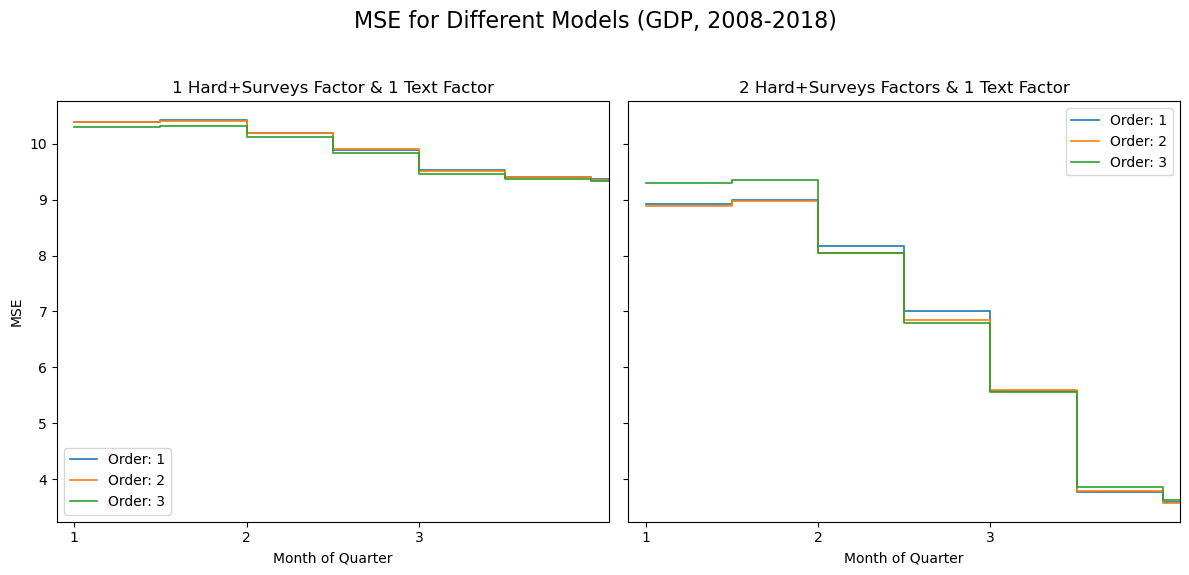

In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd

vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]
q_var = 'GDP'
text_type = "topics_BPW"
estimation_period = "2007"
num_topics = "200"
source = "all"

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Define the directory containing MSE files
mse_dir = f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}"

# Create a figure with 1 row and 2 columns of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Loop over the number of HardSurveys factors (1 or 2)
for i, num_factors in enumerate(range(1, 3)):
    ax = axs[i]
    # Within each subplot, loop over factor orders 1 to 3
    for order in range(1, 4):
        # Construct file name based on the model's parameters
        factors_str = f"HS_{num_factors}_{order}"
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_file_path = os.path.join(mse_dir, mse_file_name)
        
        # Load the MSE values from file
        mse_df = pd.read_csv(mse_file_path)
        # Construct y values based on the vintages
        y_values = [mse_df[col].iloc[0] for col in vintage_col_names]
        
        # Extend the y-values so the step function holds the last value
        y_extended = y_values.copy()
        y_extended.append(y_values[-1]) # Repeat the last value
        
        # Plot the step function for the current model
        ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                 label=f"Order: {order}")
        
    # Customize the subplot
    ax.set_xlabel("Month of Quarter")
    # Set ticks only at 1, 2, and 3 to mark the beginning of each month
    ax.set_xticks([1, 2, 3])
    ax.set_xlim(0.9, 4.1)
    ax.set_title(f"{num_factors} Hard+Surveys Factor{'s' if num_factors > 1 else ''} & 1 Text Factor")
    if i == 0:  # Only the leftmost subplot gets the y-axis label
        ax.set_ylabel("MSE")
    ax.legend()

plt.suptitle(f"MSE for Different Models ({q_var}, 2008-2018)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", exist_ok=True)
base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_2008-2018_{q_var}")
plt.savefig(f"{base_filename}.png", format="png")
plt.savefig(f"{base_filename}.eps", format="eps")

plt.show()

Plot MSE values for all models evaluated over the 2008–2010 and 2011-2018 periods.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


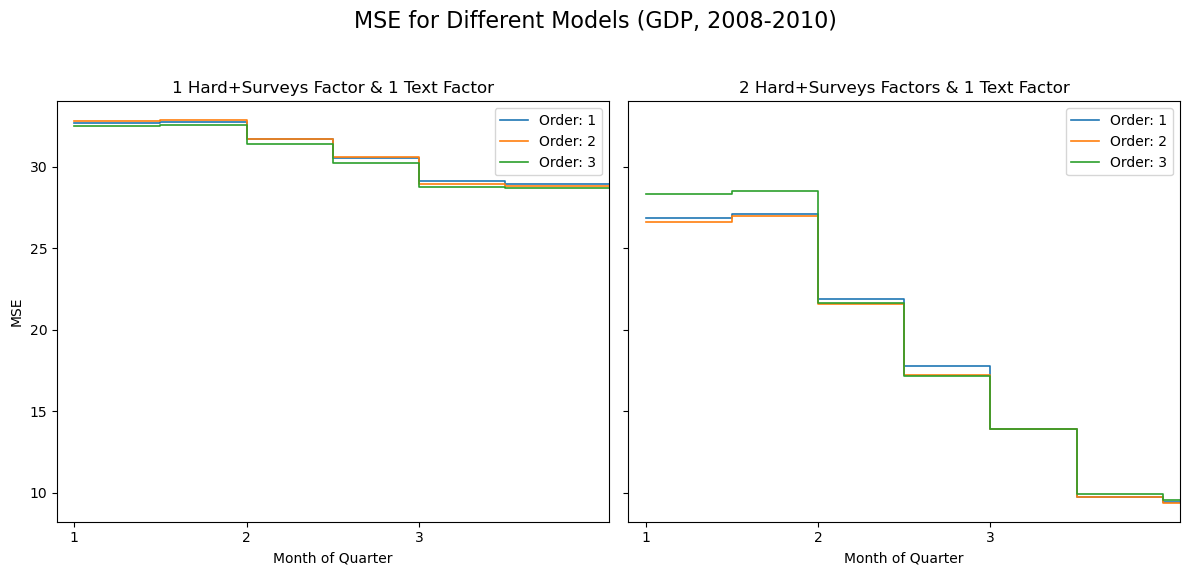

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


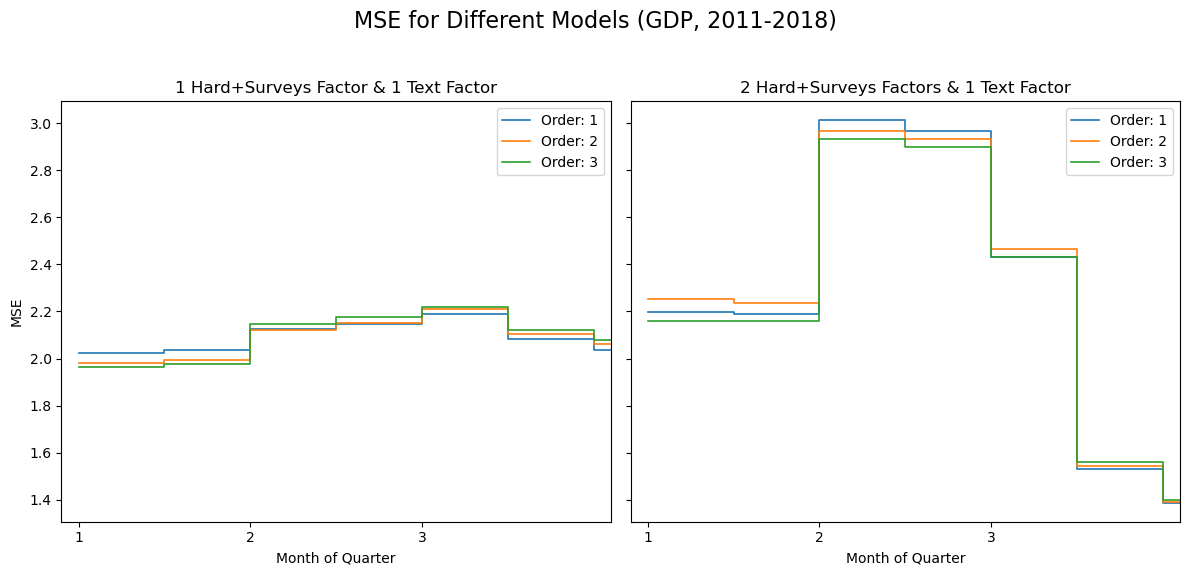

In [3]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'GDP'
text_type = "topics_BPW"
estimation_period = "2007"
num_topics = "200"
source = "all"
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}"
actual_growth_file = f"../{q_var}_growth_actual.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Define two periods
periods = {
    "2008-2010": lambda df: df["date_float"] < 2011,
    "2011-2018": lambda df: df["date_float"] >= 2011
}

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Loop over each period and create a separate figure
for period_label, period_filter in periods.items():
    
    # Create a figure with 1 row and 2 columns of subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
    
    # Loop over the number of HardSurveys factors (1 or 2)
    for i, num_factors in enumerate(range(1, 3)):
        ax = axs[i]
        # Within each subplot, loop over factor orders 1 to 3
        for order in range(1, 4):
            # Construct forecast file name, e.g., "forecasts_GDP_HS_1_1.csv"
            factors_str = f"HS_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)
    
            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)
            
            # Merge forecasts with actual growth 
            merged = pd.merge(forecasts, actual_growth, on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)
            
            # Filter merged data for the current period
            merged_period = merged[ period_filter(merged) ]
            
            # Calculate MSE for each vintage column over the filtered period
            mse_dict = {}
            for col in vintage_col_names:
                mse = ((merged_period[col] - merged_period["growth"]) ** 2).mean()
                mse_dict[col] = mse
                
            # Construct y values based on the vintages
            y_values = [mse_dict[col] for col in vintage_col_names]
            
            # Extend the y-values so the step function holds the last value
            y_extended = y_values.copy()
            y_extended.append(y_values[-1]) # Repeat the last value
            
            # Plot the step function for the current model (order)
            ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                    label=f"Order: {order}")
            
        # Customize the subplot
        ax.set_xlabel("Month of Quarter")
        # Set ticks only at 1, 2, and 3 to mark the beginning of each month
        ax.set_xticks([1, 2, 3])
        ax.set_xlim(0.9, 4.1)
        ax.set_title(f"{num_factors} Hard+Surveys Factor{'s' if num_factors > 1 else ''} & 1 Text Factor")
        if i == 0:  # Only the leftmost subplot gets the y-axis label
            ax.set_ylabel("MSE")
        ax.legend()
   
    plt.suptitle(f"MSE for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()

Plot forecasts vs actual growth values for all models and different time periods (2008-2010, 2008-2018, and 2011-2018).

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


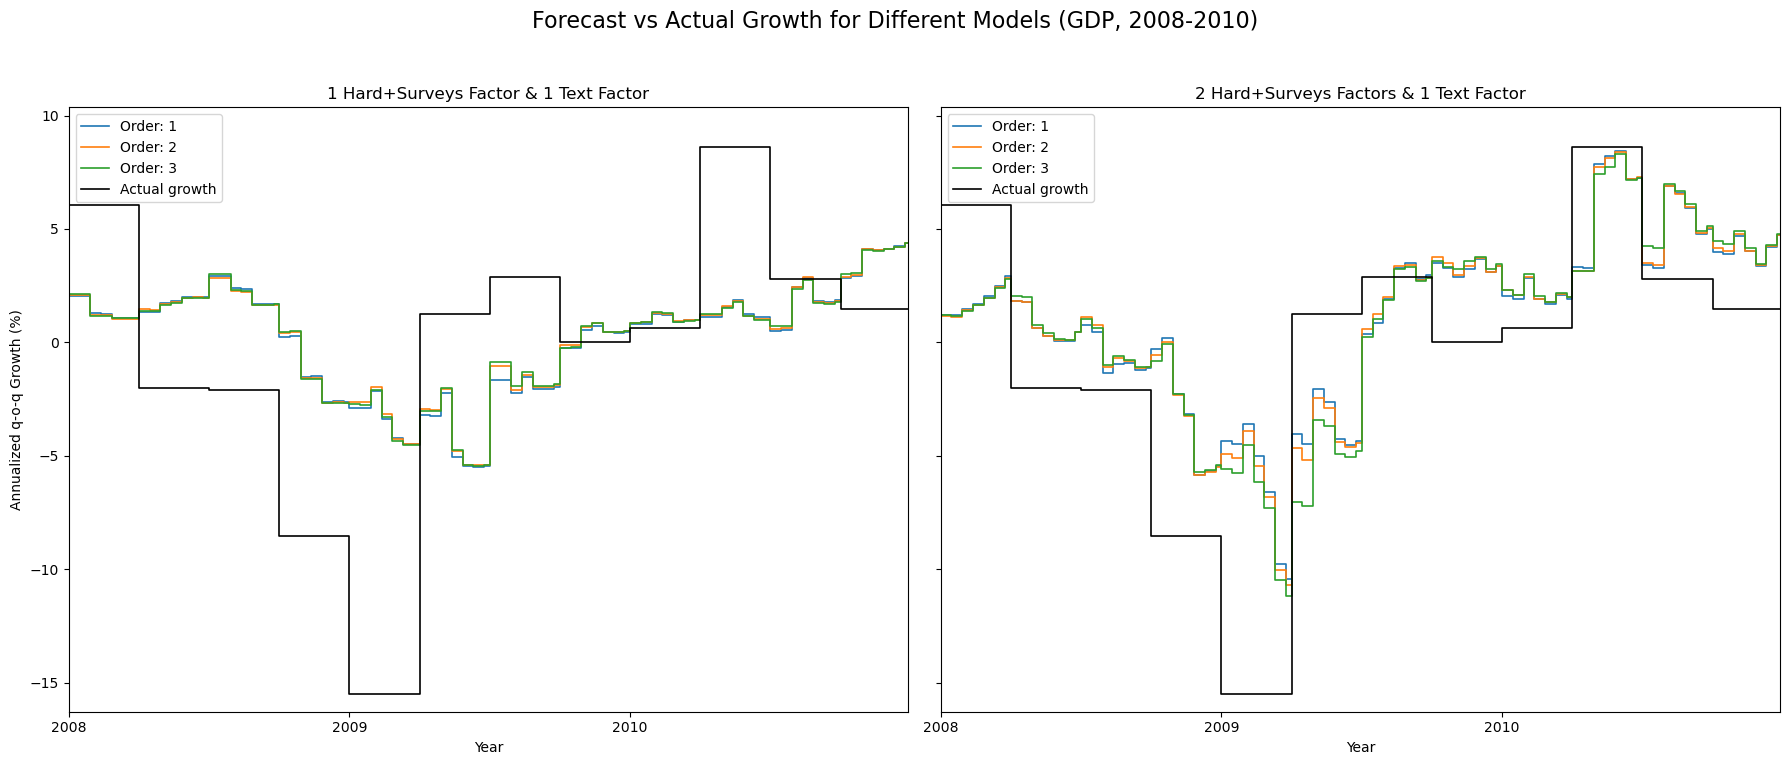

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


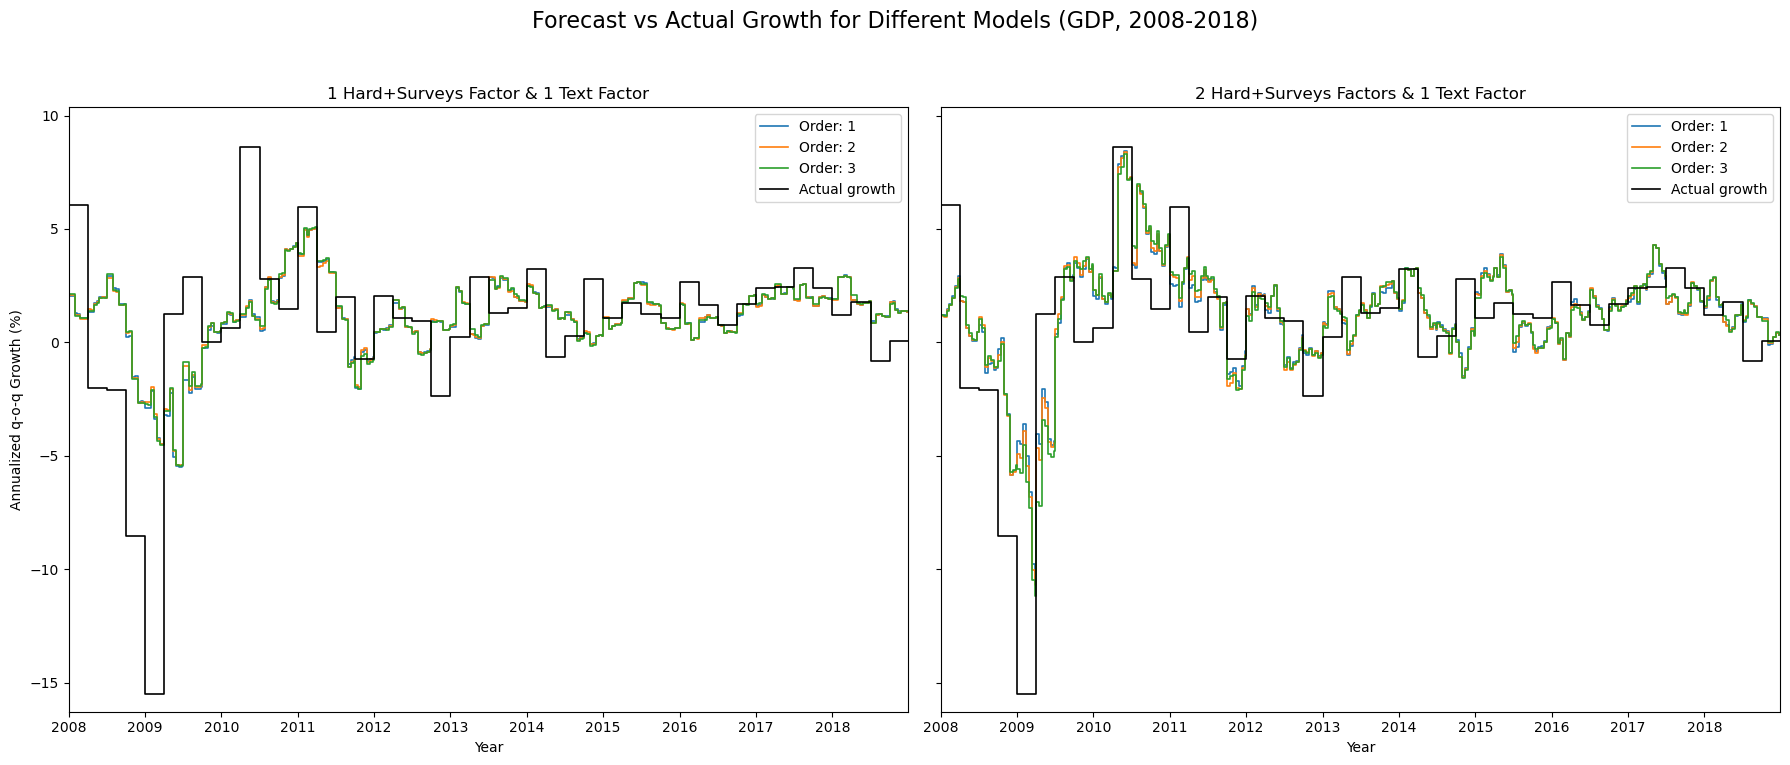

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


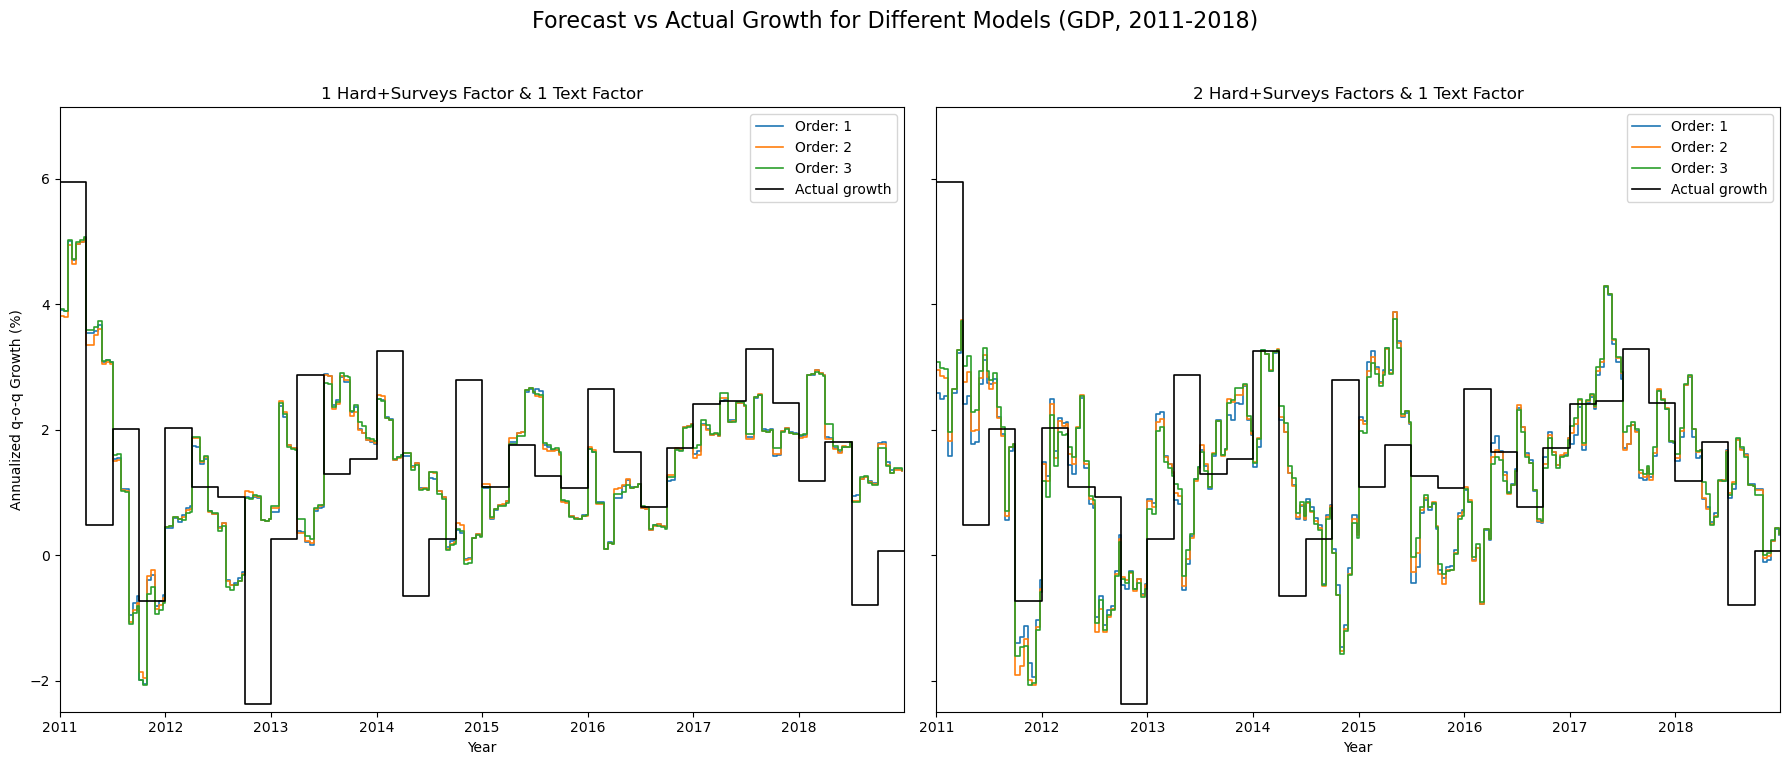

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Convert quarter strings like "2008-03" into a float (e.g. 2008.00 for Q1, 2008.25 for Q2, etc.)
def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'GDP'
text_type = "topics_BPW"
estimation_period = "2007"
num_topics = "200"
source = "all"
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}"
actual_growth_file = f"../{q_var}_growth_actual.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Assign 7 small offsets within each quarter, so each quarter has 7 forecast points
offsets = np.linspace(0, 0.23, 7)

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Build x,y arrays for the actual growth
x_act = actual_growth["date_float"].tolist()
y_act = actual_growth["growth"].tolist()

# Define period configurations: x-axis limits and tick positions for each period
period_configs = {
    "2008-2010": {"xlim": (2008, 2010.99), "xticks": list(range(2008, 2011))},
    "2008-2018": {"xlim": (2008, 2018.99), "xticks": list(range(2008, 2019))},
    "2011-2018": {"xlim": (2011, 2018.99), "xticks": list(range(2011, 2019))}
}

# Loop over each period configuration to create and save separate plots
for period_label, config in period_configs.items():
    
    # Extend the actual growth arrays so that the step function continues until the end of the x-axis
    if period_label in ["2008-2018", "2011-2018"]:
        x_act_extended = x_act.copy()
        x_act_extended.append(config["xlim"][1])
        y_act_extended = y_act.copy()
        y_act_extended.append(y_act[-1])
    else:
        x_act_extended = x_act
        y_act_extended = y_act

    # Create a figure with 1 row and 2 columns for the two Hard+Surveys factor counts
    fig, axs = plt.subplots(1, 2, figsize=(18, 8), sharey=True)

    # Loop over the number of HardSurveys factors (1 or 2)
    for i, num_factors in enumerate([1, 2]):
        ax = axs[i]

        # For each HardSurveys factor count, plot forecasts for orders 1, 2, and 3
        for order in range(1, 4):

            # Construct forecast file name, e.g., "forecasts_GDP_HS_1_1.csv"
            factors_str = f"HS_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)

            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)

            # Merge forecasts with actual growth dates
            merged = pd.merge(forecasts, actual_growth[['date']], on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)

            # Build forecast x and y arrays 
            x_fore = []
            y_fore = []
            for idx, row in merged.iterrows():
                base_x = row["date_float"]
                # For each of the 7 vintage columns, define an x-position and take that forecast value
                for j, col in enumerate(vintage_col_names):
                    x_fore.append(base_x + offsets[j])
                    y_fore.append(row[col])

            # Plot the forecast step curve for the current order
            ax.step(x_fore, y_fore, where='post', linewidth=1.2, label=f"Order: {order}")

        # Plot actual growth as a step plot in each subplot
        ax.step(x_act_extended, y_act_extended, where='post', color='black', linewidth=1.2, label="Actual growth")

        # Customize the subplot
        ax.set_xlabel("Year")
        ax.set_xlim(config["xlim"][0], config["xlim"][1])
        ax.set_xticks(config["xticks"])
        
        # Set y-axis limits based on the data within the period range
        x_min, x_max = config["xlim"]
        def filter_points(x_arr, y_arr, x_min, x_max):
            return [y for x, y in zip(x_arr, y_arr) if x_min <= x <= x_max]

        # Filter y-values
        y_filtered = filter_points(x_fore, y_fore, x_min, x_max)
        y_act_filtered = filter_points(x_act_extended, y_act_extended, x_min, x_max)
        
        # Combine all filtered y-values
        combined_y = y_filtered + y_act_filtered
        ax.set_ylim(1.05 * min(combined_y), 1.2 * max(combined_y))
        
        ax.set_title(f"{num_factors} Hard+Surveys Factor{'s' if num_factors > 1 else ''} & 1 Text Factor")
        if i == 0:
            ax.set_ylabel("Annualized q-o-q Growth (%)")
        ax.legend()
        
    plt.suptitle(f"Forecast vs Actual Growth for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_forecast_vs_actual_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()